# GARCH Model

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [104]:
class IGGARCH:
    def __init__(self, params=None):
        """
        Initialize the IG-GARCH model with parameters based on 
        equations (10)-(15) from Augustyniak et al. (2021).
        
        Parameters:
        params : dictionary containing the model parameters
            - lambda: equity risk premium (eq. 10)
            - eta: skewness parameter (eq. 10)
            - sigma2: unconditional variance (eq. 13)
            - rho_s: persistence of short-run component (eq. 12)
            - rho_q: persistence of long-run component (eq. 13)
            - c_s: leverage effect parameter for short-run component (eq. 14)
            - c_q: leverage effect parameter for long-run component (eq. 15)
            - a_s: innovation parameter for short-run component (eq. 14)
            - a_q: innovation parameter for long-run component (eq. 15)
        """
        self.params = params if params is not None else {}
        self.h = None  # conditional variance (eq. 11)
        self.s = None  # short-run component (eq. 12)
        self.q = None  # long-run component (eq. 13)
    
    def initialize_state(self, returns):
        """
        Initialize state variables (h, s, q) based on return data.
        This sets up the initial values for equations (11)-(13) from Augustyniak et al. (2021).
        """
        n = len(returns)
        
        # Initialize with unconditional variance
        sigma2 = self.params.get('sigma2', np.var(returns))
        self.h = np.zeros(n + 1)
        self.s = np.zeros(n + 1)
        self.q = np.zeros(n + 1)
        
        # Set initial values
        self.h[0] = sigma2
        self.s[0] = 0  # Short-run component starts at 0
        self.q[0] = sigma2  # Long-run component starts at unconditional variance (eq. 13)

    def simulate(self, returns, r=0.0):
        """
        Simulate the IG-GARCH model using given returns and parameters.
        Implements equations (10)-(15) from Augustyniak et al. (2021) with
        numerical safeguards.
        """
        n = len(returns)
        
        # Extract parameters
        lam = self.params['lambda']
        eta = self.params['eta']
        sigma2 = self.params['sigma2']
        rho_s = self.params['rho_s']
        rho_q = self.params['rho_q']
        c_s = self.params['c_s']
        c_q = self.params['c_q']
        a_s = self.params['a_s']
        a_q = self.params['a_q']
        

        
        # Initialize state variables if they haven't been already
        if self.h is None or len(self.h) <= n:
            self.initialize_state(returns)
        
        
        for t in range(n):
            h_t = self.h[t]
            s_t = self.s[t]
            q_t = self.q[t]
            
            # Mean equation (eq. 10)
            y_t = returns[t]
            mean_t = r + lam * h_t
            
            # Compute normalized residual with safeguards
            error_term = y_t - mean_t
            
            # Ensure eta division is stable
            if abs(eta) < 1e-10:
                print(f"Warning: eta is very small: {eta}")
                eta_safe = 1e-10 if eta > 0 else -1e-10
            else:
                eta_safe = eta
                
            z_t = np.abs(error_term / eta_safe)
            
            # Safeguard for division by z_t
            eps = 1e-10
            z_t_safe = max(z_t, eps) if z_t != 0 else eps
            
            # Cap h_t^2 to prevent overflow
            h_t_squared = min(h_t**2, 1e-10)
            
            # Compute innovation terms with safeguards
            try:
                # Compute parts of innovation separately for debugging
                term1_s = c_s * z_t
                term2_s = a_s * h_t_squared / z_t_safe
                term3_s = c_s * h_t / (eta_safe**2)
                term4_s = a_s * (eta_safe**2) * h_t
                term5_s = a_s * (eta_safe**4)
                
                zeta_s = term1_s + term2_s - term3_s - term4_s - term5_s
                
                # Same for q
                term1_q = c_q * z_t
                term2_q = a_q * h_t_squared / z_t_safe
                term3_q = c_q * h_t / (eta_safe**2)
                term4_q = a_q * (eta_safe**2) * h_t
                term5_q = a_q * (eta_safe**4)
                
                zeta_q = term1_q + term2_q - term3_q - term4_q - term5_q
                
                
                # Clip extremely large innovations
                zeta_max = 10 * sigma2
                zeta_s = np.clip(zeta_s, -zeta_max, zeta_max)
                zeta_q = np.clip(zeta_q, -zeta_max, zeta_max)
            
                
            except (ZeroDivisionError, OverflowError, FloatingPointError) as e:
                print(f"Numeric error at t={t}: {str(e)}")
                zeta_s = 0
                zeta_q = 0
            
            # Update state variables (eq. 12-13)
            self.s[t+1] = rho_s * s_t + zeta_s
            self.q[t+1] = sigma2 + rho_q * (q_t - sigma2) + zeta_q
            
            # Ensure non-negativity of variance components
            self.s[t+1] = max(self.s[t+1], 0)
            self.q[t+1] = max(self.q[t+1], 1e-10)
            
            # Update total variance (eq. 11)
            self.h[t+1] = self.s[t+1] + self.q[t+1]
            
            # Safety check for extreme values
            if self.h[t+1] > 1000 * sigma2:
                print(f"Warning: extreme variance at t={t+1}: h={self.h[t+1]:.8e}")
        
        return self.h[1:n+1]  # Return conditional variances
    
    def fit(self, returns, r=0.0):
        """
        Fit the IG-GARCH model to return data using maximum likelihood.
        Based on the likelihood of the IG distribution in equation (10) from Augustyniak et al. (2021).
        
        Parameters:
        returns : array-like, shape (n_samples,)
            The asset returns
        r : float
            Risk-free rate
        """
        # Define the negative log-likelihood function to minimize
        def neg_log_likelihood(params):
            lam = params[0]
            eta = params[1]
            sigma2 = params[2]
            rho_s = params[3]
            rho_q = params[4]
            c_s = params[5]
            c_q = params[6]
            a_s = params[7]
            a_q = params[8]
            
            # Update parameters dictionary
            self.params = {
                'lambda': lam,
                'eta': eta,
                'sigma2': sigma2,
                'rho_s': rho_s,
                'rho_q': rho_q,
                'c_s': c_s,
                'c_q': c_q,
                'a_s': a_s,
                'a_q': a_q
            }
            
            # Initialize state variables
            self.initialize_state(returns)
            
            n = len(returns)
            log_likelihood = 0.0
            
            for t in range(n):
                # Calculate conditional variance components
                h_t = self.h[t]
                s_t = self.s[t]
                q_t = self.q[t]
                
                # Compute the log-likelihood contribution for this observation
                y_t = returns[t]
                mean_t = r + lam * h_t
                
                # Extract the error term
                error_term = y_t - mean_t
                
                # Ensure eta division is stable - same as in simulate
                if abs(eta) < 1e-10:
                    eta_safe = 1e-10 if eta > 0 else -1e-10
                else:
                    eta_safe = eta
                    
                # Calculate z_t with absolute value - same as in simulate
                z_t = np.abs(error_term / eta_safe)
                
                # Safeguard for division by z_t - same as in simulate
                eps = 1e-10
                z_t_safe = max(z_t, eps) if z_t != 0 else eps
                
                # Cap h_t^2 to prevent overflow - same as in simulate
                h_t_squared = min(h_t**2, 1e-10)

                try:
                    # IG distribution log-likelihood with safeguards
                    mu = h_t / eta_safe**2
                    lambda_param = h_t_squared / eta_safe**4

                    # By solving log of CDF for IG(μ,λ) we get the following log-likelihood
                    # Using z_t_safe to avoid division by zero or small numbers
                    log_likelihood_term = 0.5 * np.log(lambda_param) - 0.5 * np.log(2 * np.pi) - 1.5 * np.log(z_t_safe) - \
                                        (lambda_param * (z_t_safe - mu)**2) / (2 * mu**2 * z_t_safe)
                    
                    # Check for invalid values
                    if np.isnan(log_likelihood_term) or np.isinf(log_likelihood_term):
                        log_likelihood_term = -1e8  # Large negative penalty
                        
                    log_likelihood += log_likelihood_term
                    
                    # Compute innovation terms - same approach as in simulate
                    term1_s = c_s * z_t
                    term2_s = a_s * h_t_squared / z_t_safe
                    term3_s = c_s * h_t / (eta_safe**2)
                    term4_s = a_s * (eta_safe**2) * h_t
                    term5_s = a_s * (eta_safe**4)
                    
                    zeta_s = term1_s + term2_s - term3_s - term4_s - term5_s
                    
                    # Same for q
                    term1_q = c_q * z_t
                    term2_q = a_q * h_t_squared / z_t_safe
                    term3_q = c_q * h_t / (eta_safe**2)
                    term4_q = a_q * (eta_safe**2) * h_t
                    term5_q = a_q * (eta_safe**4)
                    
                    zeta_q = term1_q + term2_q - term3_q - term4_q - term5_q
                    
                    # Clip extremely large innovations - same as in simulate
                    zeta_max = 10 * sigma2
                    zeta_s = np.clip(zeta_s, -zeta_max, zeta_max)
                    zeta_q = np.clip(zeta_q, -zeta_max, zeta_max)
                    
                except (ZeroDivisionError, OverflowError, FloatingPointError) as e:
                    # Return a large penalty for parameter combinations causing numerical issues
                    return 1e10
                
                # Update state variables (eq. 12-13) - same as in simulate
                self.s[t+1] = rho_s * s_t + zeta_s
                self.q[t+1] = sigma2 + rho_q * (q_t - sigma2) + zeta_q
                
                # Ensure non-negativity of variance components - same as in simulate
                self.s[t+1] = max(self.s[t+1], 0)
                self.q[t+1] = max(self.q[t+1], 1e-10)
                
                # Update total variance (eq. 11) - same as in simulate
                self.h[t+1] = self.s[t+1] + self.q[t+1]
                
                # Safety check for extreme values - similar to simulate
                if self.h[t+1] > 1000 * sigma2:
                    return 1e10  # Large penalty for extreme variance
            
            return -log_likelihood
        
        # Initial parameter guess based on Table 2 in Augustyniak et al. (2021)
        initial_params = [
            self.params.get('lambda', 2.5),
            self.params.get('eta', -0.0006),
            self.params.get('sigma2', 1.2*10**-4),
            self.params.get('rho_s', 0.8),
            self.params.get('rho_q', 0.99),
            self.params.get('c_s', 1.7*10**-6),
            self.params.get('c_q', 2.5*10**-6),
            self.params.get('a_s', 2.2*10**7),
            self.params.get('a_q', 3.6*10**7)
        ]
        
        # Parameter constraints based on Table 2 in Augustyniak et al. (2021)
        bounds = [
            (-10, 10),           # lambda
            (-0.001, -0.0001),   # eta (adjusted to match paper's values)
            (1*10**-6, 1*10**-3),        # sigma2
            (0.5, 0.999),        # rho_s
            (0.98, 0.9999),      # rho_q
            (1*10**-7, 1*10**-5),        # c_s (adjusted to match paper's values)
            (1*10**-7, 1*10**-5),        # c_q (adjusted to match paper's values)
            (1*10**6, 1*10**8),          # a_s (adjusted to match paper's values)
            (1*10**6, 1*10**8)           # a_q (adjusted to match paper's values)
        ]
        
        # Minimize negative log-likelihood
        result = minimize(neg_log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')
        
        # Extract and store optimized parameters
        params = result.x
        self.params = {
            'lambda': params[0],
            'eta': params[1],
            'sigma2': params[2],
            'rho_s': params[3],
            'rho_q': params[4],
            'c_s': params[5],
            'c_q': params[6],
            'a_s': params[7],
            'a_q': params[8]
        }
        
        # Re-run to store final state variables
        self.initialize_state(returns)
        self.simulate(returns, r)
        
        return result
    
    def forecast(self, horizon=1):
        """
        Forecast conditional variance h_t for horizon steps ahead.
        Based on the dynamics from equations (11)-(13) from Augustyniak et al. (2021).
        
        Parameters:
        horizon : int
            Number of steps ahead to forecast
            
        Returns:
        array-like, shape (horizon,)
            Forecasted conditional variances
        """
        # Extract parameters
        sigma2 = self.params['sigma2']
        rho_s = self.params['rho_s']
        rho_q = self.params['rho_q']
        
        # Get latest state values
        s_t = self.s[-1]
        q_t = self.q[-1]
        
        # Initialize forecasts
        s_forecasts = np.zeros(horizon)
        q_forecasts = np.zeros(horizon)
        h_forecasts = np.zeros(horizon)
        
        # Generate forecasts
        for h in range(horizon):
            if h == 0:
                s_forecasts[h] = rho_s * s_t
                q_forecasts[h] = sigma2 + rho_q * (q_t - sigma2)
            else:
                s_forecasts[h] = rho_s * s_forecasts[h-1]
                q_forecasts[h] = sigma2 + rho_q * (q_forecasts[h-1] - sigma2)
            
            h_forecasts[h] = s_forecasts[h] + q_forecasts[h]
        
        return h_forecasts

In [105]:
# Create mock returns data
np.random.seed(42)  # For reproducibility
n_samples = 1000

# Calculate the appropriate standard deviation
target_variance = 1.2*10**-4
target_std = np.sqrt(target_variance)  # Should be around 0.011

# Generate returns with the correct scale
returns = np.random.normal(0, target_std, n_samples)

print(f"Generated returns with variance: {np.var(returns):.8e}")
print(f"Target unconditional variance: {target_variance:.8e}")

Generated returns with variance: 1.14948599e-04
Target unconditional variance: 1.20000000e-04


In [106]:
# Test the initialization
def test_initialization():
    # Test with parameters
    params = {
        'lambda': 2.6591,
        'eta': -6.0027e-4,
        'sigma2': 1.1676e-4,
        'rho_s': 7.9656e-1,
        'rho_q': 9.9124e-1,
        'c_s': 1.7172e-6,
        'c_q': 2.4548e-6,
        'a_s': 2.1765e7,
        'a_q': 3.6037e7
    }
    model = IGGARCH(params)
    assert model.params == params
    print("Initialization test passed!")
    return model

In [107]:
# Test state initialization
def test_state_initialization(model, returns):
    model.initialize_state(returns)
    assert len(model.h) == len(returns) + 1
    assert model.h[0] == model.params['sigma2']
    assert model.s[0] == 0
    assert model.q[0] == model.params['sigma2']
    print("State initialization test passed!")

In [108]:
# Test simulation
def test_simulation(model, returns):
    h = model.simulate(returns)
    assert len(h) == len(returns)
    
    # Check h = s + q relationship with a tolerance for numerical precision
    for t in range(1, len(returns) + 1):
        # Use relative tolerance for larger values
        rel_diff = abs((model.h[t] - (model.s[t] + model.q[t])) / max(model.h[t], 1e-10))
        assert rel_diff < 1e-6, f"h != s + q at t={t}: {model.h[t]} != {model.s[t] + model.q[t]}"
    
    print("Simulation test passed!")
    return h

In [109]:
# Run the tests
model = test_initialization()
test_state_initialization(model, returns)
h = test_simulation(model, returns)

Initialization test passed!
State initialization test passed!
Simulation test passed!


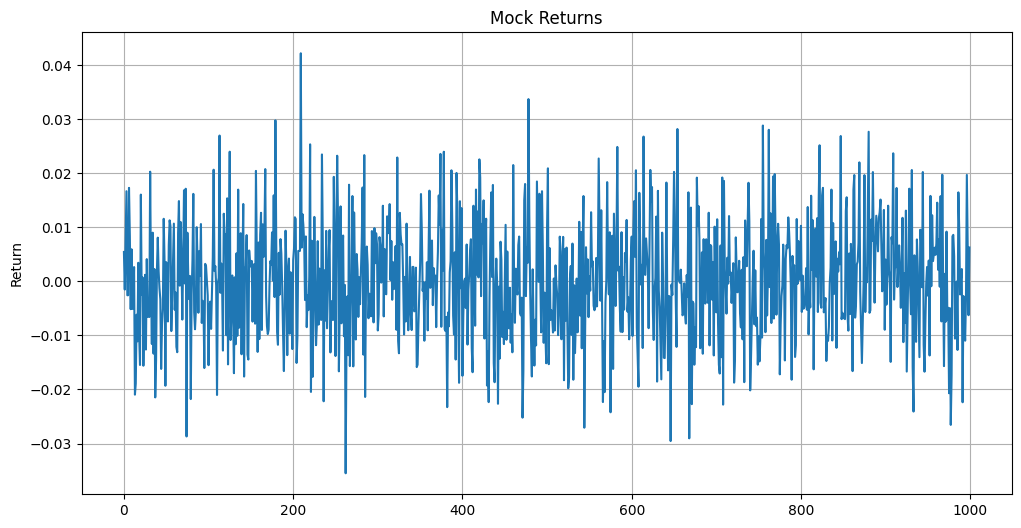

In [110]:
# Plot 1: Returns
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title('Mock Returns')
plt.ylabel('Return')
plt.grid(True)
plt.show()

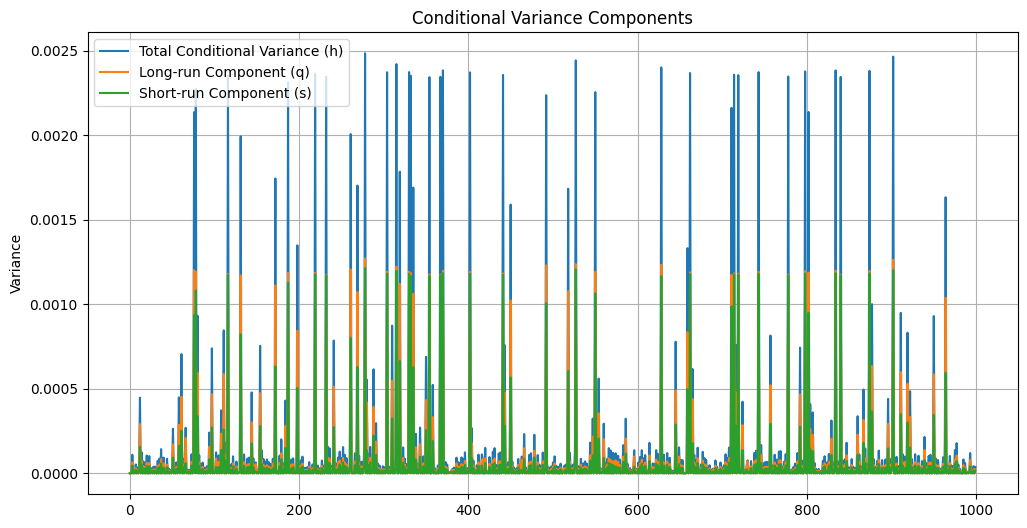

In [111]:
# Plot 2: Conditional Variance and its Components
plt.figure(figsize=(12, 6))


plt.plot(h, label='Total Conditional Variance (h)')

plt.plot(model.q[1:], label='Long-run Component (q)')

plt.plot(model.s[1:], label='Short-run Component (s)')

plt.title('Conditional Variance Components')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

Min volatility: 0.000010, Max volatility: 0.049851
Mean volatility: 0.006399, Median volatility: 0.003494


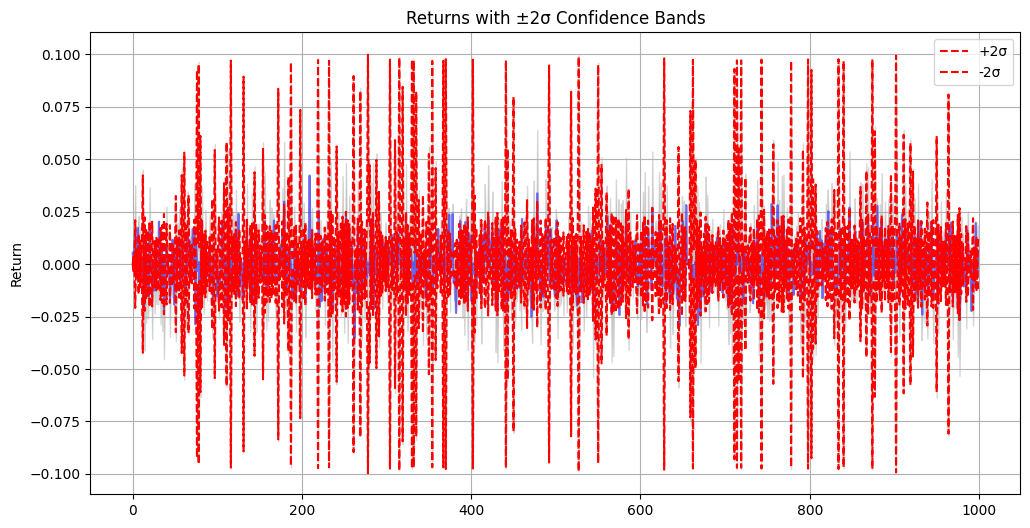

In [112]:
# Plot 3: Returns with Conditional Volatility Bands
plt.figure(figsize=(12, 6))
plt.plot(returns, color='blue', alpha=0.5)

# Check if volatility bands are reasonable
volatility = np.sqrt(h)
print(f"Min volatility: {np.min(volatility):.6f}, Max volatility: {np.max(volatility):.6f}")
print(f"Mean volatility: {np.mean(volatility):.6f}, Median volatility: {np.median(volatility):.6f}")

# If bands are too wide, you might need to scale them
scaling_factor = 1.0  # Adjust this if needed

# Add bands with potential scaling
plt.fill_between(range(len(returns)), 
                 returns + 2 * scaling_factor * volatility, 
                 returns - 2 * scaling_factor * volatility, 
                 color='gray', alpha=0.3)
plt.plot(2 * scaling_factor * volatility, color='red', linestyle='--', label='+2σ')
plt.plot(-2 * scaling_factor * volatility, color='red', linestyle='--', label='-2σ')
plt.title('Returns with ±2σ Confidence Bands')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
print(f"Actual model parameters used:")
for key, value in model.params.items():
    print(f"{key}: {value}")

Actual model parameters used:
lambda: 2.6591
eta: -0.00060027
sigma2: 0.00011676
rho_s: 0.79656
rho_q: 0.99124
c_s: 1.7172e-06
c_q: 2.4548e-06
a_s: 21765000.0
a_q: 36037000.0


In [114]:
# Try to fit the model
try:
    print("\nFitting the model...")
    result = model.fit(returns)
    print(f"Optimization successful: {result.success}")
    print(f"Message: {result.message}")
    
    # Print the fitted parameters
    print("\nFitted Parameters:")
    for key, value in model.params.items():
        print(f"{key}: {value}")
    
except Exception as e:
    print(f"Error during model fitting: {e}")
    


Fitting the model...


Optimization successful: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH

Fitted Parameters:
lambda: 9.943426962999837
eta: -0.0009714045133916094
sigma2: 1e-06
rho_s: 0.5
rho_q: 0.9992673223384069
c_s: 1.0134092067056541e-07
c_q: 9.597597794438904e-06
a_s: 21765000.000840392
a_q: 36037000.0


In [115]:
def plot_garch_results(returns, model):
    """
    Plot the returns data and estimated volatility.
    """
    # Create a figure with two subplots
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[1, 1])
    
    # Plot returns
    ax1 = plt.subplot(gs[0])
    ax1.plot(returns, color='blue', alpha=0.7)
    ax1.set_title('Returns')
    ax1.set_ylabel('Return')
    ax1.grid(True, alpha=0.3)
    
    # Plot volatility (standard deviation)
    ax2 = plt.subplot(gs[1], sharex=ax1)
    h_series = np.sqrt(model.h[:-1]) # Convert variance to standard deviation
    ax2.plot(h_series, color='red', linewidth=1.5)
    ax2.set_title('Estimated Volatility (Standard Deviation)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.grid(True, alpha=0.3)
    
    # Add a horizontal line at the target volatility level
    target_std = np.sqrt(model.params['sigma2'])
    ax2.axhline(y=target_std, color='green', linestyle='--', alpha=0.7, 
                label=f'Target σ: {target_std:.4f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_volatility_components(model):
    """
    Plot the volatility components.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot total volatility and components
    ax.plot(np.sqrt(model.h[:-1]), label='Total Volatility', color='red', linewidth=2)
    ax.plot(np.sqrt(np.maximum(model.s[:-1], 0)), label='Short-run Component', 
            color='blue', linestyle='--')
    ax.plot(np.sqrt(np.maximum(model.q[:-1], 0)), label='Long-run Component', 
            color='green', linestyle='-.')
    
    ax.set_title('Volatility Components')
    ax.set_xlabel('Time')
    ax.set_ylabel('Volatility (Standard Deviation)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

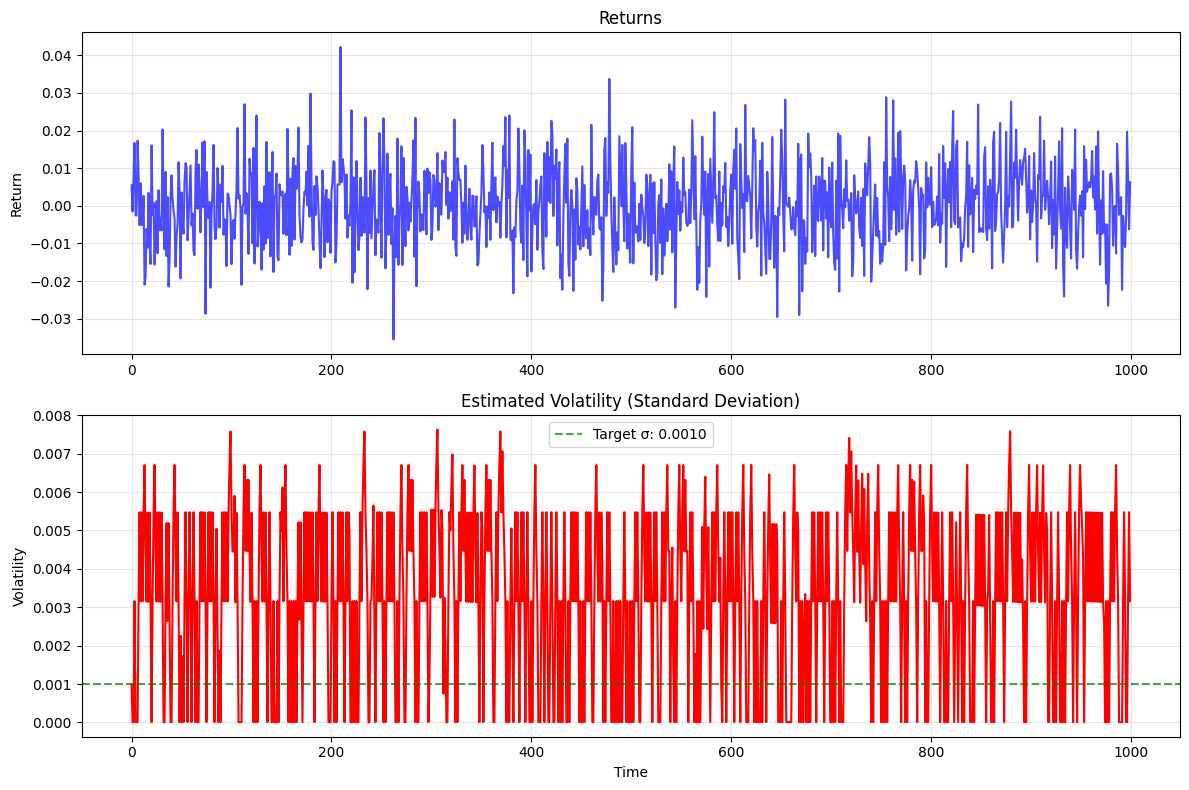

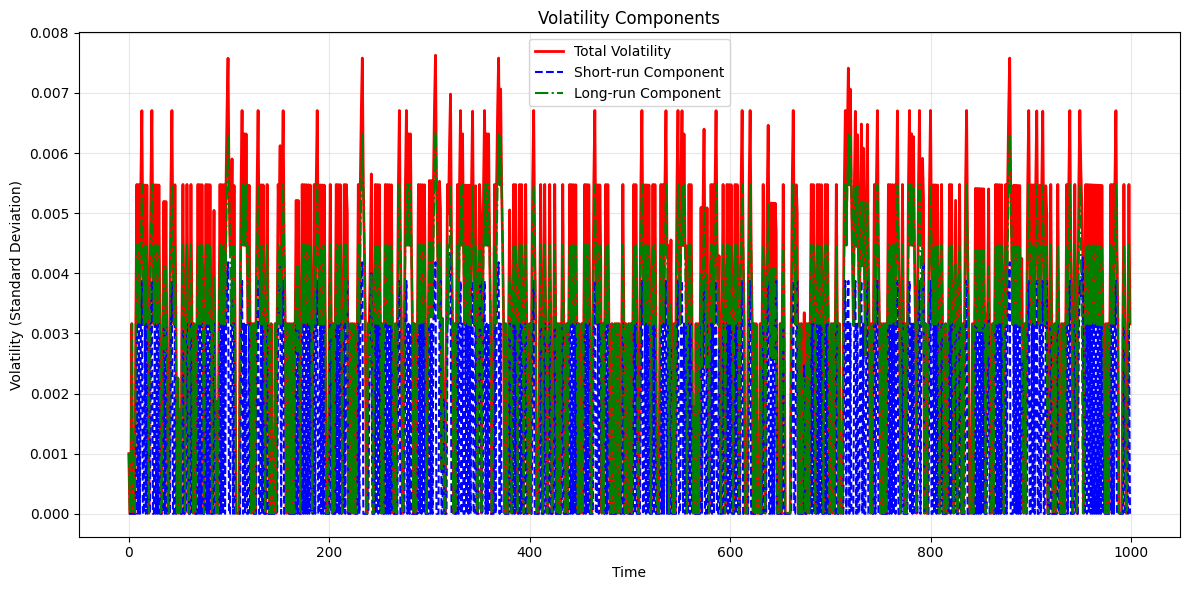

In [116]:
# Plot the results from the fitted model
plot_garch_results(returns, model)
plot_volatility_components(model)